https://diane-space.tistory.com/316

##### [시계열] ML Approaches for Time Series

- 노이즈에서 크게 벗어난 큰 ‘ 피크 ‘또는 ‘ 높은 데이터 포인트 ‘

    - 피크의 폭은 미리 결정될 수 없음
    - 피크의 높이가 다른 값과 명확하고 크게 벗어남
    - 사용 된 알고리즘은 실시간을 계산 (따라서 새로운 데이터 포인트마다 변경)
    => 신호를 트리거하는 경계 값을 구성

### 1️⃣ 주어진 현재 값을 예측 값으로 고려

#### 1. 데이터 생성, 창(windows) 과 기초 모델(baseline model) 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import copy as cp
import cv2
from PIL import Image

- 3개의 랜덤 변수인 x1,x2,x3의 합성 데이터
- 변수들의 일부 시차들의 선형 조합에 약간의 노이즈를 추가한 반응 변수y


In [2]:
N = 600

t = np.arange(0, N, 1).reshape(-1,1)
# 각 숫자에다가 랜덤 오차항을 더함 
t = np.array([t[i] + np.random.rand(1)/4 for i in range(len(t)) ]) 
# 각 숫자에다가 랜덤 오차항을 뺌
t = np.array([t[i] - np.random.rand(1)/7 for i in range(len(t)) ])
t = np.array(np.round(t,2))

- 데이터에 높은 비 선형성을 유도할 목적으로 지수연산자와 로그연산자를 포함

In [3]:
x1 = np.round((np.random.random(N) * 5).reshape(-1,1),2)
x2 = np.round((np.random.random(N) * 5).reshape(-1,1),2)
x3 = np.round((np.random.random(N) * 5).reshape(-1,1),2)

n = np.round((np.random.random(N)*2).reshape(-1,1),2)

y = np.array([((np.log(np.abs(2 + x1[t]))  - x2[t-1]**2) + 
               0.02 * x3[t-3]*np.exp(x1[t-1])) for t in range(len(t))])

y = np.round(y+n ,2 )

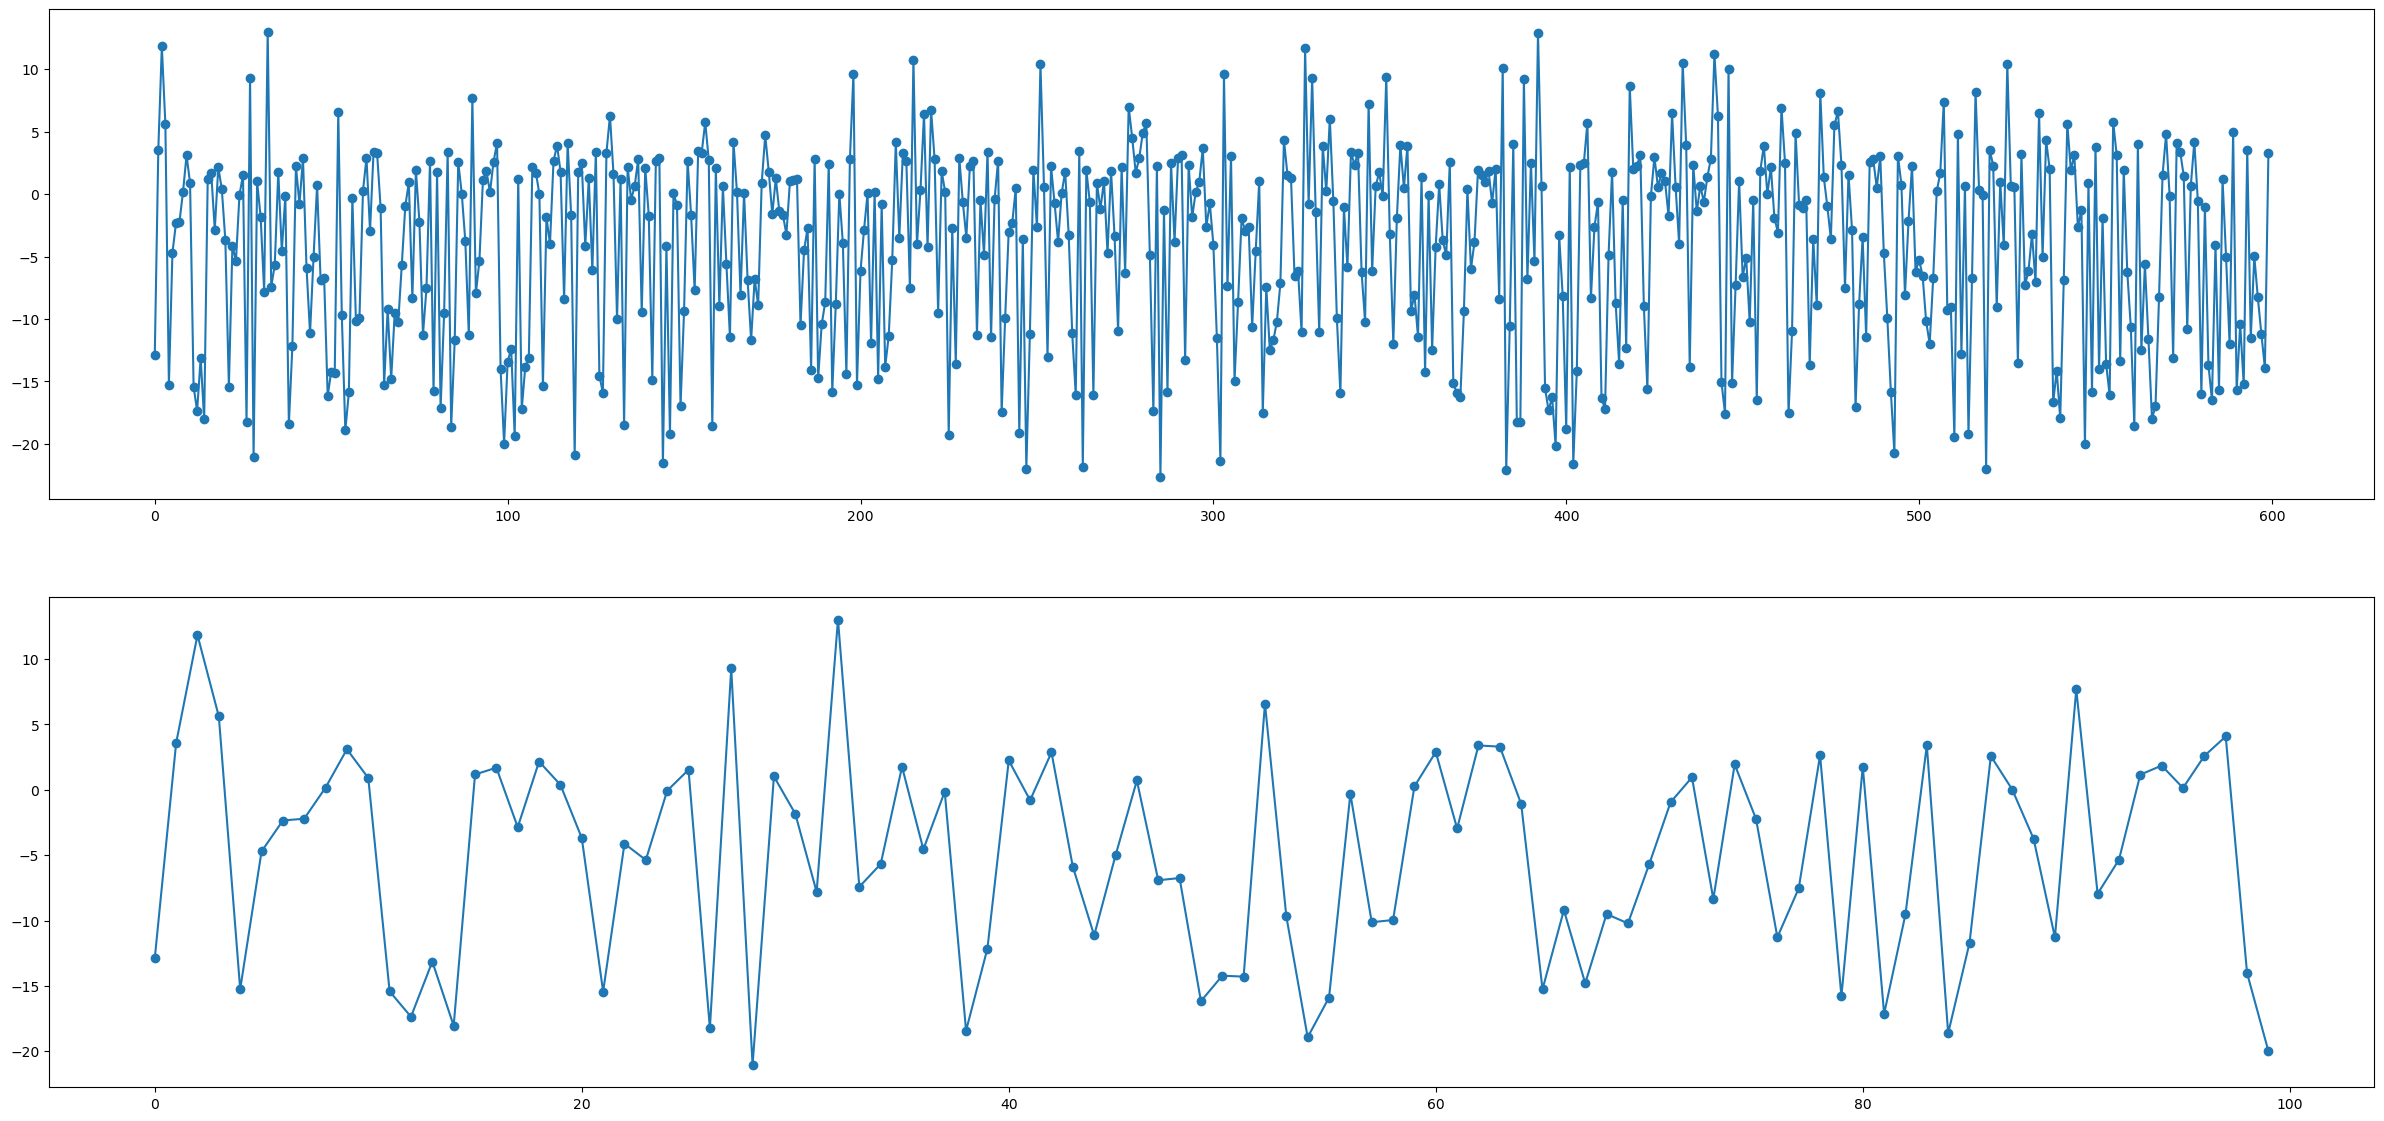

In [4]:
fig, (ax1,ax2) = plt.subplots(nrows=2)
fig.set_size_inches(30,14)

ax1.plot(y, marker = "o") # 600일간 데이터 
ax2.plot(y[:100], marker = "o") # 100일간 데이터 

- 반응변수 y 함수는 직접적으로 주어진 지점에서 그들의 값 뿐만 아니라 독립 변수의 시차에 연관 (correlated) 

#### 2. 창 windows 형성
- 모든 모델들이 따르는 접근은 정확한 예측을 달성하기 위해 우리가 가지고 있는 정보를 과거로부터 주어진 시점에서 가능한 가장 완전한 정보를 모델에 제공하는 고정된 창(windows) 으로 재구성
- 반응 변수 자체의 이전 값을 독립 변수로 제공하는 것이 모형에 어떤 영향을 미치는지 확인

- w 크기로 선택된 (그리고 고정된) 창
    - 이 경우에는 창의 크기가 4 
    - 모델이 t+1 지점에서의 예측을 통해 창에 포함된 정보를 매핑
- 반응의 크기는 r 이 있는데, 우리는 과거에 몇가지 타임 스텝을 예측
    - many-to-many 관계

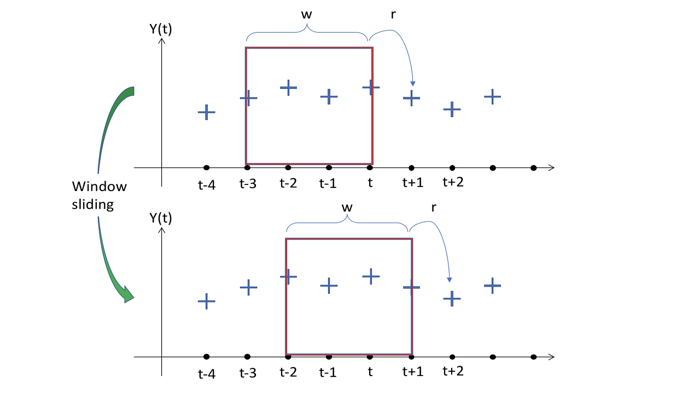

In [15]:
img = Image.open('다운로드.png') # 이미지 파일명 또는 파일 위치
img = img.resize((700, 400))
img

- Sliding Window 의 효과를 확인
    - 모델이 매핑함수를 찾기위해 갖게되는 input과 output의 다음 짝은 window를 한 스텝 미래로 움직임

In [16]:
dataset = pd.DataFrame(np.concatenate((t,x1,x2,x3,y), axis=1),
                       columns = ['t','x1','x2','x30','y'])
dataset[:7]

,t,x1,x2,x30,y
0,0.03,2.70,0.07,3.00,-12.88
1,1.02,4.52,0.31,2.59,3.57
2,1.98,3.87,0.58,1.37,11.83
3,3.07,4.67,4.81,4.68,5.61
4,4.21,3.84,3.00,1.26,-15.26
5,5.03,0.75,2.30,0.21,-4.72
6,5.90,0.15,1.96,4.24,-2.35


- 관찰 사이의 경과시간이 얼마인지

In [17]:
deltaT = np.array([(dataset.t[i+1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate( (np.array([0]), deltaT))
deltaT[:7]

array([0.  , 0.99, 0.96, 1.09, 1.14, 0.82, 0.87])

- 함수가 하는 것은 window 안에 포함되어있는 모든 정보를 압축 (flatten) 하는 것
    - W window 내의 모든 값이며, 예측을 원하는 시간의 타임스탬프

- 새로운 예측치로 반응변 수의 이전의 값을 포함하고 있는 지에 따라 의존

- l=n−(w+r)+1개의 windows
    - Y(0) 의 첫번째 값에 대한 이전 정보가 없기 때문에 첫번째 행이 손실

- 모든 시차들은 모델의 새로운 예측치로 행동합니다 ( 이 시각화에서 Y의 이전 값이 포함되지 않았지만, 같은 값을 Xi 로 따름)
    - (경과한) 타임스탬프는 여기서 우리가 원하는 예측값이 ∆t(4)가 되길 원할 것이며, 그에 따르는 예측에 대한 값이 Y(4)가 되야함
    - 모든 첫번째  ∆t(0) 가 0으로 초기화된다    ====> 모든 window를 같은 범위로 표준화 하기를 원하기 때문

In [18]:
dataset.insert(1,'∆t',deltaT)
dataset.head(3)

,t,∆t,x1,x2,x30,y
0,0.03,0.00,2.70,0.07,3.00,-12.88
1,1.02,0.99,4.52,0.31,2.59,3.57
2,1.98,0.96,3.87,0.58,1.37,11.83


- 파라미터를 변화하면서 다른 windows를 구성하는 객체

In [19]:
class WindowSlider(object):
    def __init__(self, window_size = 5):
        """
        Window Slider object 
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature 
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#obeservation - w)
        p: final predictors - (# predictors *w)
        """
        self.w = window_size 
        self.o = 0
        self.r = 1
        self.l = 0
        self.p = 0
        self.names = [] 
        
    def re_init(self, arr):
        """
        Helper function to initializate to 0 a vector
        """
        arr = np.cumsum(arr)
        return arr - arr[0]

    def collect_windows(self, X, window_size = 5, offset = 0, previous_y = False):
        """
        Input: X is the input matrix, each column is a variable 
        Returns : different mappings window-output
        """
        cols = len(list(X))-1
        N = len(X)

        self.o = offset
        self.w = window_size 
        self.l = N - (self.w + self.r) + 1 
        if not previous_y:
            self.p = cols * self.w
        if previous_y:
            self.p = (cols +1) * self.w

        # Create the names of the variables in the window 
        # Check first if we need to create that for the response itself 
        if previous_y: 
            x = cp.deepcopy(X)
        if not previous_y:
            x = X.drop(X.columns[-1], axis=1)

        for j , col in enumerate(list(x)):
            for i in range(self.w):
                name = col + ("(%d)" % (i+1))  
                self.names.append(name)

        # Incorporate the timestampes where we want to predict 
        for k in range(self.r):
            name = "∆t" + ("(%d)" % (self.w + k +1))
            self.names.append(name)
            
        self.names.append("Y")

        df = pd.DataFrame(np.zeros(shape = (self.l, (self.p + self.r +1))),
                         columns = self.names)

        # Populate by rows in the new dataframe 
        for i in range(self.l):
            slices = np.array([])

            # Flatten the lags of predictors 
            for p in range(x.shape[1]):
                line = X.values[i:self.w+i,p]
                # Reinitialization at every window for ∆T 
                if p == 0:
                    line = self.re_init(line)

                # Concatenate the lines in one slice 
                slices = np.concatenate((slices,line))

            # Incorporate the timestamps where we want to predict 
            line = np.array([self.re_init(X.values[i:i+self.w +self.r,0])[-1]])
            y = np.array(X.values[self.w + i + self.r -1, -1]).reshape(1,)
            slices = np.concatenate((slices,line,y))

            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices 

        return df

- Windows 생성
    - 모든 예측치, 남은 변수들의 과거 타임 스텝의 기록(window_length) 과  ∆t 의 누적 합을 어떻게 windows가 가져옴

In [28]:
trainset = dataset[:400]
testset = dataset[400:]

In [29]:
w = 5 

train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:],
                                                 previous_y = False)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:],
                                                 previous_y = False)

train_constructor_y_inc = WindowSlider()
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:],
                                                             previous_y = True)

test_constructor_y_inc = WindowSlider()
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:],
                                                             previous_y = True)

train_windows.head(3)

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x30(1),x30(2),x30(3),x30(4),x30(5),∆t(6),Y
0,0.0,0.99,1.95,3.04,4.18,2.70,4.52,3.87,4.67,3.84,...,0.58,4.81,3.00,3.00,2.59,1.37,4.68,1.26,5.00,-4.72
1,0.0,0.96,2.05,3.19,4.01,4.52,3.87,4.67,3.84,0.75,...,4.81,3.00,2.30,2.59,1.37,4.68,1.26,0.21,4.88,-2.35
2,0.0,1.09,2.23,3.05,3.92,3.87,4.67,3.84,0.75,0.15,...,3.00,2.30,1.96,1.37,4.68,1.26,0.21,4.24,5.15,-2.21


In [30]:
test_windows.head(3)

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x30(1),x30(2),x30(3),x30(4),x30(5),∆t(6),Y
0,0.0,0.99,2.09,3.05,4.13,0.28,2.54,0.86,1.75,0.15,...,4.14,0.25,0.46,4.46,4.35,2.23,3.47,0.25,4.99,2.49
1,0.0,1.10,2.06,3.14,4.00,2.54,0.86,1.75,0.15,5.00,...,0.25,0.46,2.81,4.35,2.23,3.47,0.25,2.76,5.09,5.72
2,0.0,0.96,2.04,2.90,3.99,0.86,1.75,0.15,5.00,2.35,...,0.46,2.81,3.24,2.23,3.47,0.25,2.76,1.57,4.89,-8.35


- 예측치(prediction) = 현재(current)
- 타임스탬프의 예측으로 마지막 값(각 예측 지점에서 현재 값)을 주는 간단한 모델

In [31]:
# ________________ Y_pred = current Y ________________ 

bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

bl_train_y = pd.DataFrame(bl_trainset['y'])
bl_train_y_pred = bl_train_y.shift(periods = 1) 

bl_y = pd.DataFrame(bl_testset['y'])
bl_y_pred = bl_y.shift(periods = 1) 

bl_residuals = bl_y_pred - bl_y 
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print("RMSE = %.2f" % bl_rmse)
print("Time to train  = 0 secconds")

RMSE = 11.08
Time to train  = 0 secconds


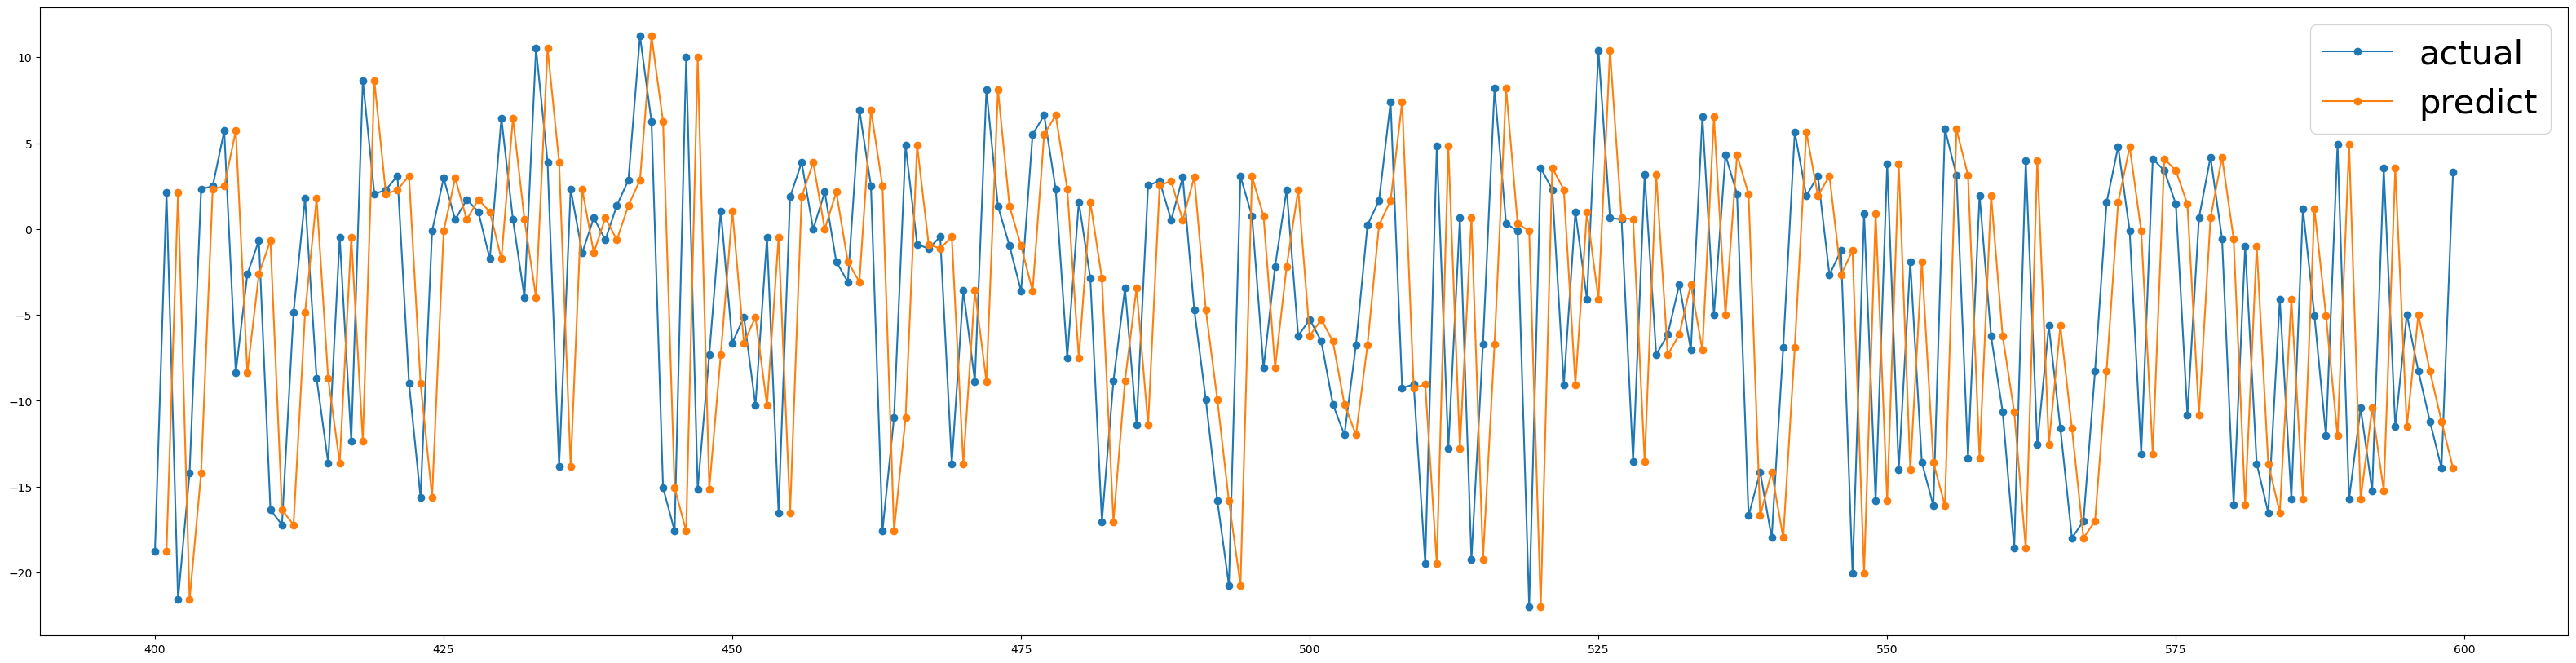

In [32]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,10)


ax1.plot(bl_y, marker = "o" , label = "actual") # 100일간 데이터 
ax1.plot(bl_y_pred, marker = "o", label = "predict") # 100일간 데이터 
ax1.legend(prop={'size':30})

### 2️⃣ 다중 선형 회귀 (Multiple Linear Regression)

In [33]:
# ______________ MULTIPLE LINEAR REGRESSION ______________ #

import sklearn
from sklearn.linear_model import LinearRegression
import time

lr_model = LinearRegression()
lr_model.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1])

t0 = time.time()
lr_y = testset["y"].values
lr_y_fit = lr_model.predict(trainset.iloc[:,:-1])
lr_y_pred = lr_model.predict(testset.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y 
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2))/len(lr_residuals))
print("RMSE = %.2f" % lr_rmse)
print("Time to train = %.2f seconds" % (tF-t0))

RMSE = 8.07
Time to train = 0.08 seconds


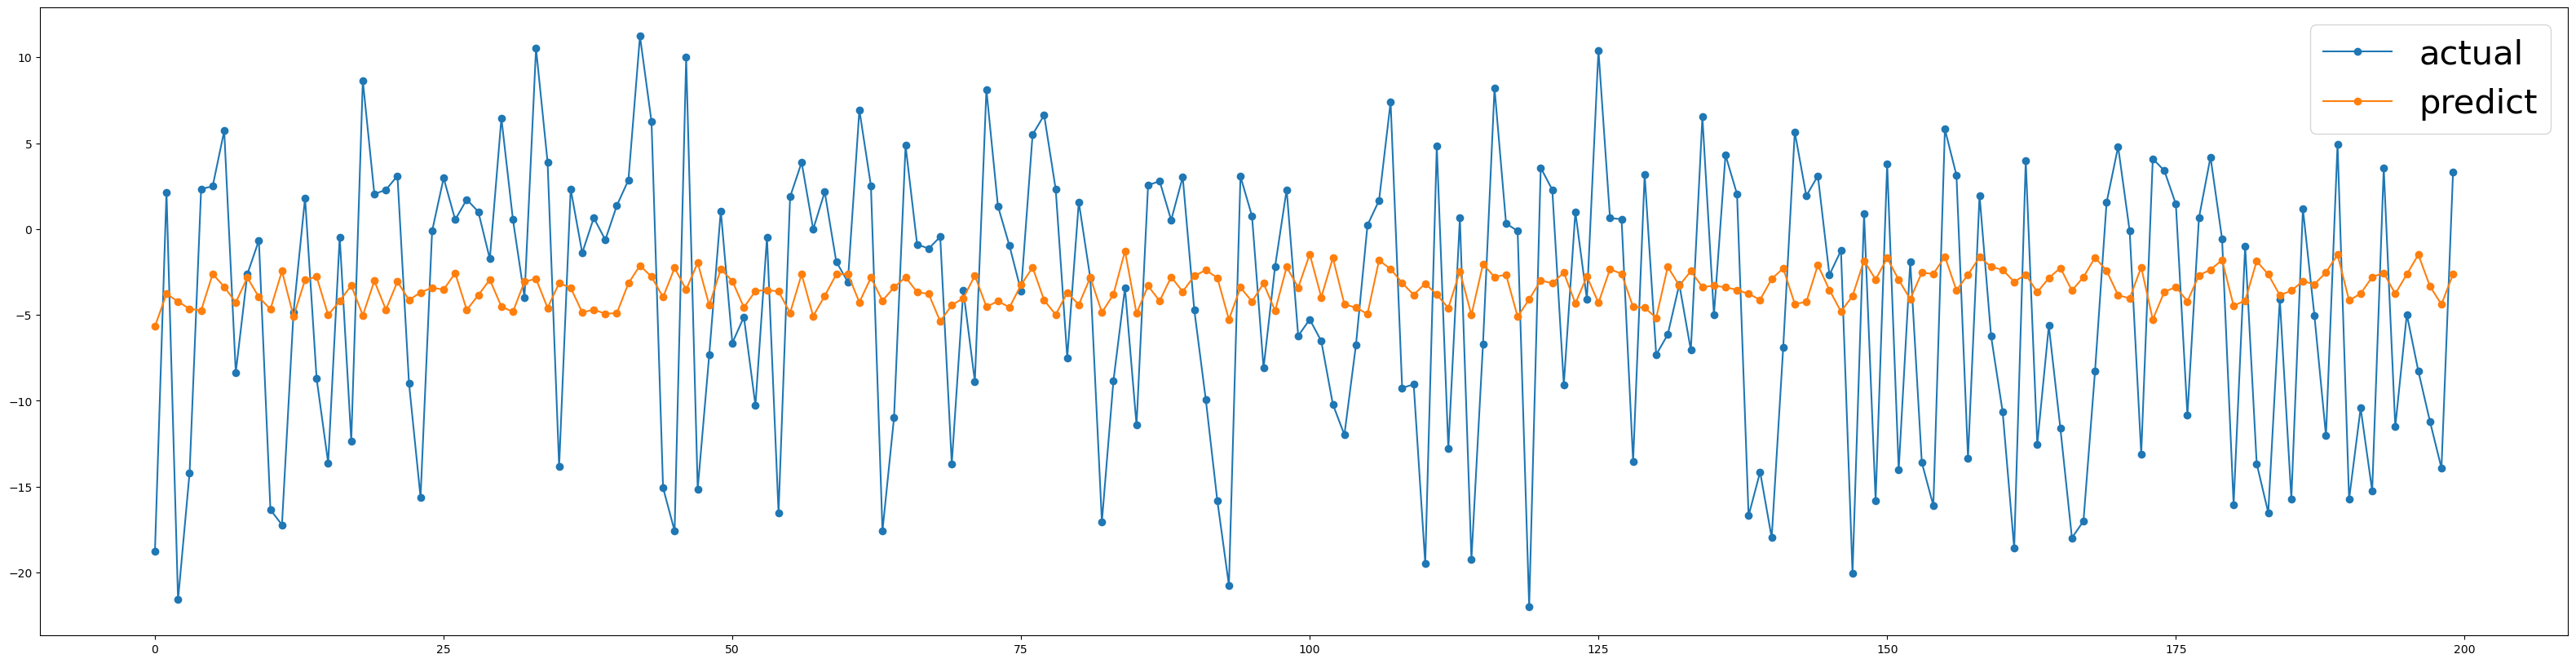

In [34]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,10)


ax1.plot(lr_y, marker = "o" , label = "actual") # 100일간 데이터 
ax1.plot(lr_y_pred, marker = "o", label = "predict") # 100일간 데이터 
ax1.legend(prop={'size':30})

- 다중 선형 회귀 모형이 얼마나 반응 변수의 동작을 포착하지 못하는지 확인 가능
    - 반응변수와 독립변수 간의 비- 선형 관계 때문
    
- 주어진 시간에 반응변수에게 영향을 미치는 것은 변수들간의 시차
    - 이 관계를 매핑할 수 없는 모형에 대해 서로 다른 행에 값(values)들이 있음

### 3️⃣ Windows를 가진 다중 선형 회귀 ( MLR with the Windows) 

In [35]:
# ___________ MULTIPLE LINEAR REGRESSION ON WINDOWS ___________ 

lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
lr_y = test_windows['Y'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y 
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2))/ len(lr_residuals))
print("RMSE = %.2f" %lr_rmse)
print("Time to Train = %.2f seconds" % (tF-t0))

RMSE = 2.46
Time to Train = 0.03 seconds


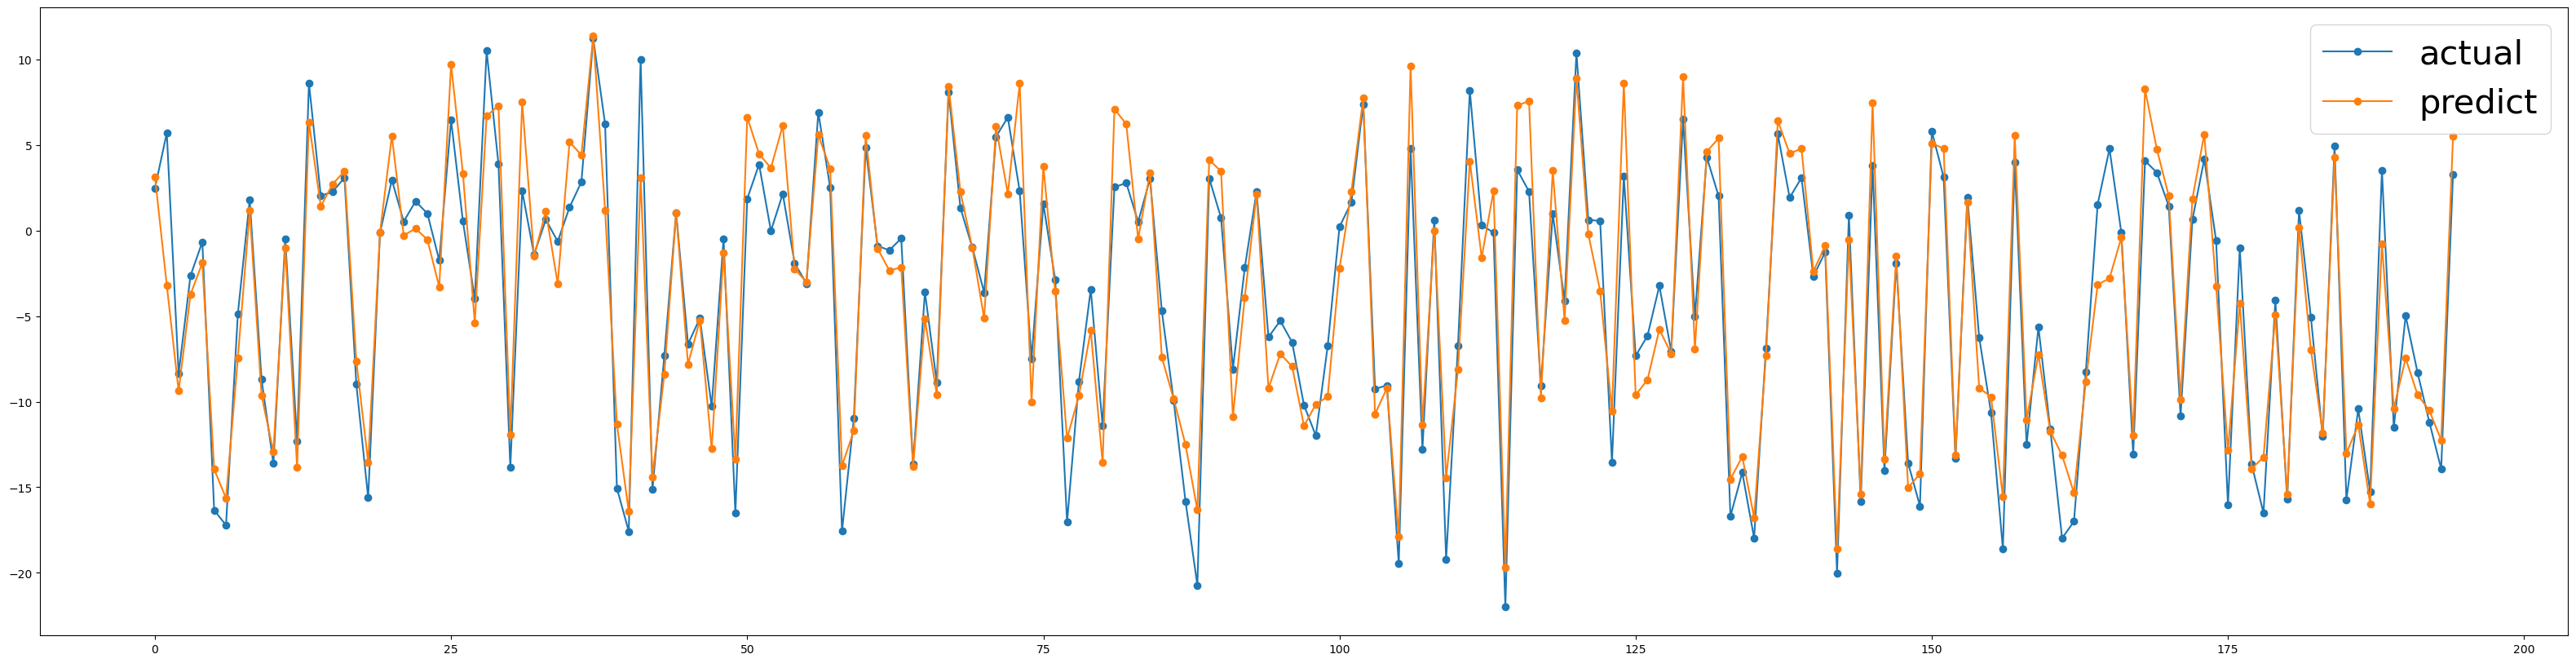

In [36]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,10)


ax1.plot(lr_y, marker = "o" , label = "actual") # 100일간 데이터 
ax1.plot(lr_y_pred, marker = "o" , label = "predict") # 100일간 데이터 
ax1.legend(prop={'size':30})

### 3️⃣ 기호 회귀분석 (Symbolic Regression)

- 주어진 데이터셋을 적합하는 최적의 모델을 찾기위한 수학적 표현의 공간을 찾는 회귀 분석의 한 유형
- 수학적 표현이 트리 구조로 표현
- 적합 함수 (fitness fuction)에 따라 측정 (RMSE)
    - 각 세대에 가장 우수한 개인들은 그들 사이를 가로지르고 탐험과 무작위성을 포함하기 위해 일부 돌연변이를 적용
    - 반복적인 알고리즘은 정지 조건이 충족될 때 끝남

In [38]:
#######################
# CREATION OF THE MODEL 
#######################

# !pip instal gplearn 
import gplearn as gpl
from gplearn.genetic import SymbolicRegressor 

# It is possible to create custom operations to be considered in the tree 
def _xexp(x):
    a = np.exp(x);
    a[np.abs(a) > 1e+9] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp , name = 'xexp', arity=1)
#function_set = ['add', 'sub','mul','div','sin','log'] # ,xexp]
function_set = ['add', 'sub','mul','div']

if 'model' in locals(): del model
model = SymbolicRegressor(population_size = 3000, 
                         tournament_size = 5,
                         generations = 25,
                         stopping_criteria = 0.1,
                         function_set = function_set,
                         metric = 'rmse',
                         p_crossover = 0.65,
                         p_subtree_mutation = 0.15,
                         p_hoist_mutation = 0.05, 
                         p_point_mutation = 0.1,
                         verbose = 1,
                         random_state = None,
                         n_jobs = -1) 

###########################################################
# TRAIN THE NETWORK AND PREDICT - Without previous values y 
###########################################################

# Train 
t0 = time.time()
model.fit(train_windows.values[:,:-1], train_windows.values[:,-1])
tF = time.time()

# Predict 
sr_y_fit = model.predict(train_windows.values[:,:-1]).reshape(-1,1)
sr_y_pred = model.predict(test_windows.values[:,:-1]).reshape(-1,1)

# Calculating Errors 
sr_residuals = sr_y_pred - testset.iloc[5:,-1].values.reshape(-1,1)
sr_rmse = np.sqrt(np.sum(np.power(sr_residuals,2))/ len(sr_residuals))
print("RMSE = %f" % sr_rmse)
print("Time to train %.2f" % (tF-t0))
print(model._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
